### Empowering Financial Insights: Predicting Customer Transactions with Advanced Machine Learning

In this notebook, we aim to predict whether customers will make a specific transaction in the future using machine learning techniques. Our approach involves various data preprocessing techniques and model building strategies to optimize performance. We will explore multiple model versions, each with different strategies for handling the data and feature engineering.

In [4]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, classification_report, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [5]:

def clean_train(df, corr_threshold=0.9):
    df = df.drop(columns=['ID_code'])
    df.fillna(df.mean(), inplace=True)
    
    # Remove highly correlated features
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    df = df.drop(columns=to_drop)
    return df


In [6]:
train = pd.read_csv(r"E:\my_work\dpi\santander-customer-transaction-prediction\train.csv")  # Adjust this path accordingly
test = pd.read_csv(r"E:\my_work\dpi\santander-customer-transaction-prediction\test.csv")  # Adjust this path accordingly


In [7]:
train.sample(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
121127,train_121127,0,9.6131,-2.1143,13.0554,7.5045,10.9825,-9.6082,6.0911,20.7475,...,4.9592,11.6716,2.7026,1.6937,18.9630,0.5340,-1.0297,6.8281,12.7679,-10.0262
2300,train_2300,0,9.0104,2.1317,13.2063,3.1717,12.1992,1.6007,5.9489,14.9465,...,11.7036,5.6827,3.2472,-0.7360,13.1448,1.5180,-5.5782,9.0235,15.3597,-13.8843
149794,train_149794,0,9.2186,-1.3859,14.3119,6.8367,10.2789,-1.9031,4.9917,18.6520,...,11.3503,8.1916,0.7751,-1.2077,12.5815,0.0725,-2.8399,8.6131,20.6564,-0.7162
98257,train_98257,0,9.5361,5.9209,9.7013,10.1064,13.6779,-18.7509,5.0724,9.7751,...,4.0458,8.0569,1.3394,2.5629,19.2282,-1.3460,-5.2953,7.3691,17.1091,-5.9701
76448,train_76448,0,7.1806,-4.0250,9.2296,3.2929,9.5268,-17.6613,5.2675,17.1938,...,3.9072,13.1772,-0.3634,1.8499,16.4632,0.5916,-2.2093,8.9506,20.2065,10.6565
112153,train_112153,0,15.1102,0.0502,12.5571,6.1808,13.8218,-3.2926,4.6421,13.8684,...,-1.3815,10.6837,2.6586,6.7618,15.0262,0.1691,-6.9916,8.2675,16.7857,-20.8800
198180,train_198180,0,11.3241,-0.7826,13.1159,3.1934,9.7421,-4.5419,6.8830,18.6400,...,-3.5379,4.1840,3.1049,9.1688,16.5700,-1.7357,3.5873,8.7284,18.6748,7.3472
158675,train_158675,0,5.9541,-2.9774,12.6883,5.5992,8.8459,7.1405,5.1921,13.6501,...,3.8829,13.3374,0.5629,-1.8254,15.2831,-1.7992,-2.9839,10.2171,16.5690,0.3773
57452,train_57452,0,11.9362,-3.4155,11.5645,6.7044,11.5067,-12.9346,4.8200,16.2719,...,6.5507,9.5444,2.1856,-2.0128,19.2254,-2.2441,3.1071,8.1133,17.7421,-21.1332
60851,train_60851,0,5.3465,-5.5319,8.1376,5.2140,11.9481,-6.9394,5.4800,15.2961,...,-1.1892,10.5011,1.8581,1.3437,13.4843,1.2380,4.3161,8.0899,17.7335,-23.6769


In [8]:
# Analysis
train.shape, test.shape

((200000, 202), (200000, 201))

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [10]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


### Data Preprocessing: Optimizing Features for Better Predictions

In order to prepare the data for modeling, we must clean and optimize it. Our data preprocessing steps include:

1. **Dropping the ID column:** The `ID_code` column is not useful for prediction.
2. **Handling missing values:** We fill any missing values with the mean of the respective feature to maintain data integrity.
3. **Removing highly correlated features:** To reduce multicollinearity, we eliminate features with a correlation higher than 0.9. This ensures that redundant features do not negatively affect model performance.

The `clean_train()` function is responsible for these steps.

In [12]:
# check duplicates
train.duplicated().sum()

0

In [13]:
# check missing values
train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

<Axes: xlabel='target', ylabel='count'>

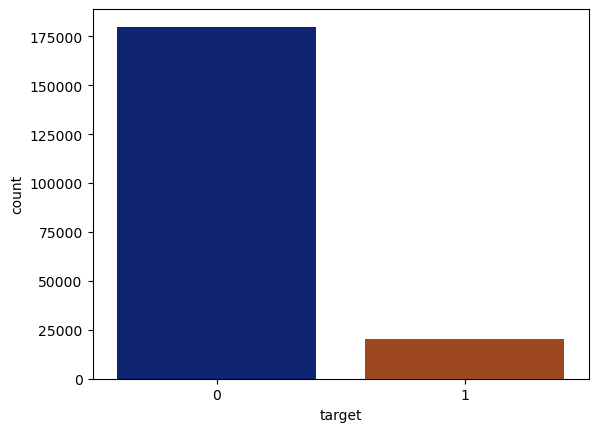

In [14]:
# check imbalance
sns.countplot(train,x='target', palette='dark')

In [15]:
# Clean and preprocess the train
def clean_train(df, corr_threshold=0.9):
    # Drop ID column (not useful for prediction)
    df = df.drop(columns=['ID_code'])

    # Check for null values and fill if necessary
    df.fillna(df.mean(), inplace=True)

    # Drop highly correlated features (correlation threshold > 0.9)
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    df = df.drop(columns=to_drop)

    return df

In [16]:
# Clean train
df = clean_train(train)

In [17]:
X = df.drop(columns=['target']).values
y = df['target']

### Version 1: Baseline Model Without Fake Rows

In this version, we build a baseline model using only the original training data without any artificial (fake) rows added. This serves as a control to understand the performance of a simple model before introducing more sophisticated techniques.

- We clean the training data using the `clean_train()` function.
- The baseline model is built using XGBoost and LightGBM, two popular gradient boosting algorithms.
- Performance metrics such as AUC-ROC and F1 score are used to evaluate the model.

In [19]:
def train_and_evaluate_models_v1(X, y, n_splits=2):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models = {
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(learning_rate=0.04, num_leaves=31, max_bin=1023, min_child_samples=1000, reg_alpha=0.1, reg_lambda=0.2, feature_fraction=1.0, bagging_freq=1, bagging_fraction=0.85, objective='binary', n_jobs=-1, n_estimators=200)
    }

    fold_metrics = {name: {'accuracy': [], 'f1_score': [], 'roc_auc': []} for name in models.keys()}
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list_train = {name: [] for name in models.keys()}
    tpr_list_test = {name: [] for name in models.keys()}

    fold_number = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict( X_train_scaled)
            y_train_pred_prob = model.predict_proba( X_train_scaled)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_f1 = f1_score(y_train, y_train_pred)
            train_auc = roc_auc_score(y_train, y_train_pred_prob)
            
            y_test_pred = model.predict(X_test_scaled)
            y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, y_test_pred_prob)

            fold_metrics[name]['accuracy'].append(test_accuracy)
            fold_metrics[name]['f1_score'].append(test_f1)
            fold_metrics[name]['roc_auc'].append(test_auc)

            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
            fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
            tpr_list_train[name].append(np.interp(mean_fpr, fpr_train, tpr_train))
            tpr_list_train[name][-1][0] = 0.0
            tpr_list_test[name].append(np.interp(mean_fpr, fpr_test, tpr_test))
            tpr_list_test[name][-1][0] = 0.0

            plt.figure(figsize=(6, 4))
            plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC (AUC = {train_auc:.2f})', lw=2, alpha=0.6)
            plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {test_auc:.2f})', lw=2, alpha=0.6)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name} - Fold {fold_number}')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()

            print(f"{name} Fold {fold_number} Metrics:")
            print(f"Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
            print(f"Training F1 Score: {train_f1:.2f}, Test F1 Score: {test_f1:.2f}")
            print(f"Training AUC: {train_auc:.2f}, Test AUC: {test_auc:.2f}")
            print(f"Classification Report for Test Set:\n{classification_report(y_test, y_test_pred)}")
            if abs(train_auc - test_auc) > 0.10:
                print("Warning: Possible Overfitting Detected")
        fold_number += 1

    plt.figure(figsize=(6, 4))
    for name in models.keys():
        mean_tpr_train = np.mean(tpr_list_train[name], axis=0)
        mean_tpr_train[-1] = 1.0
        mean_auc_train = auc(mean_fpr, mean_tpr_train)
        plt.plot(mean_fpr, mean_tpr_train, lw=2, linestyle='-', label=f'{name} Mean Training ROC (AUC = {mean_auc_train:.2f})', color='blue', alpha=0.6)

        mean_tpr_test = np.mean(tpr_list_test[name], axis=0)
        mean_tpr_test[-1] = 1.0
        mean_auc_test = auc(mean_fpr, mean_tpr_test)
        plt.plot(mean_fpr, mean_tpr_test, lw=2, linestyle='-', label=f'{name} Mean Test ROC (AUC = {mean_auc_test:.2f})', color='orange', alpha=0.6)

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final Mean ROC Curve for All Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    for name, metrics in fold_metrics.items():
        final_accuracy = np.mean(metrics['accuracy'])
        final_f1 = np.mean(metrics['f1_score'])
        final_roc_auc = np.mean(metrics['roc_auc'])
        print(f"\n{name} Final Cross-Validation Metrics:")
        print(f"Final Accuracy: {final_accuracy:.2f}")
        print(f"Final F1 Score: {final_f1:.2f}")
        print(f"Final ROC AUC: {final_roc_auc:.2f}")

    return models

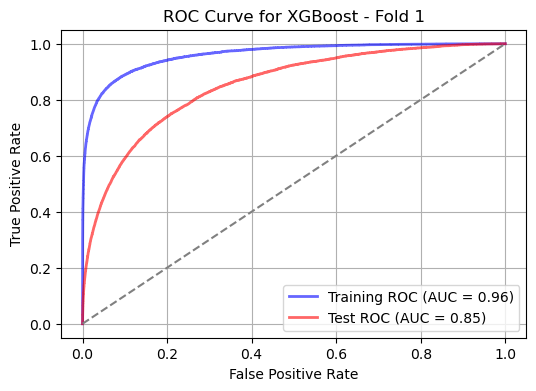

XGBoost Fold 1 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.45, Test F1 Score: 0.17
Training AUC: 0.96, Test AUC: 0.85
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     89951
           1       0.85      0.10      0.17     10049

    accuracy                           0.91    100000
   macro avg       0.88      0.55      0.56    100000
weighted avg       0.90      0.91      0.87    100000

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

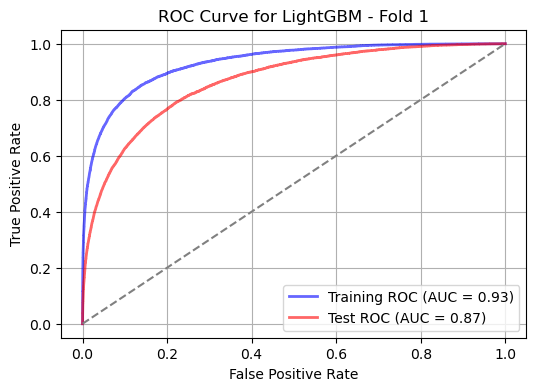

LightGBM Fold 1 Metrics:
Training Accuracy: 0.91, Test Accuracy: 0.90
Training F1 Score: 0.22, Test F1 Score: 0.11
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89951
           1       0.92      0.06      0.11     10049

    accuracy                           0.90    100000
   macro avg       0.91      0.53      0.53    100000
weighted avg       0.91      0.90      0.87    100000



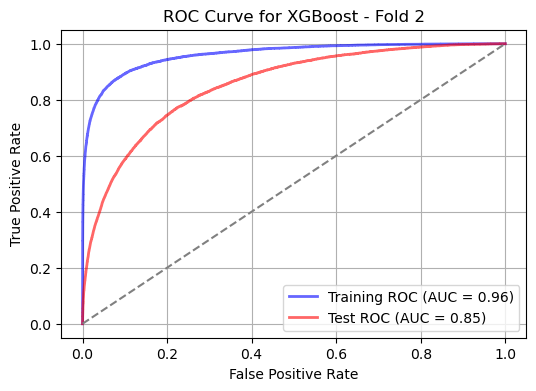

XGBoost Fold 2 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.44, Test F1 Score: 0.17
Training AUC: 0.96, Test AUC: 0.85
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     89951
           1       0.84      0.09      0.17     10049

    accuracy                           0.91    100000
   macro avg       0.87      0.54      0.56    100000
weighted avg       0.90      0.91      0.87    100000

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

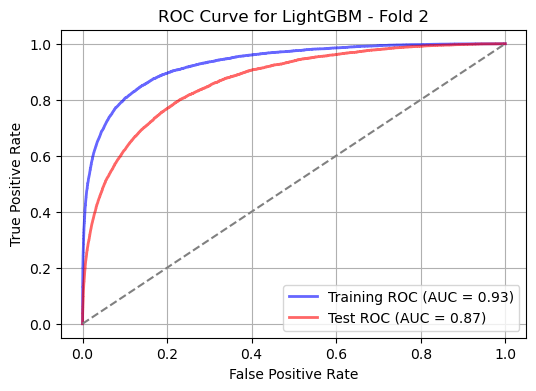

LightGBM Fold 2 Metrics:
Training Accuracy: 0.91, Test Accuracy: 0.90
Training F1 Score: 0.22, Test F1 Score: 0.11
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89951
           1       0.90      0.06      0.11     10049

    accuracy                           0.90    100000
   macro avg       0.90      0.53      0.53    100000
weighted avg       0.90      0.90      0.86    100000



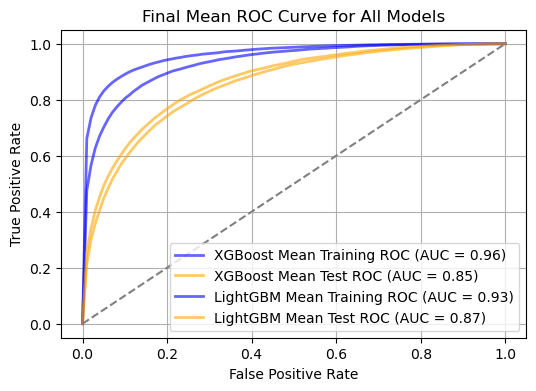


XGBoost Final Cross-Validation Metrics:
Final Accuracy: 0.91
Final F1 Score: 0.17
Final ROC AUC: 0.85

LightGBM Final Cross-Validation Metrics:
Final Accuracy: 0.90
Final F1 Score: 0.11
Final ROC AUC: 0.87


{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 'LightGBM': LGBMClassifier(bagging_fraction=0.85, bagging_freq=1, feature_fraction=1.0,
                learning_rate=0.04, max_bin=1023, min_child_samples=1000,
                n_estimators=200, n_jobs=-1, objective='bin

In [22]:
 train_and_evaluate_models_v1(X, y)

### Version 2: Model with Fake Rows (Without PCA)

In this version, we introduce synthetic or "fake" rows to augment the dataset. Fake rows are used to artificially increase the dataset's size, which can improve the model’s ability to generalize. However, we do **not** apply Principal Component Analysis (PCA) in this version.

- **Fake rows generation:** We add rows to simulate additional customer data, enhancing the dataset’s complexity and helping the model learn better from diverse examples.
- **Model building:** We use the same gradient boosting algorithms but train them on this larger dataset.

In [24]:
# Check for fake rows based on duplicated rows or abnormal values
def check_fake_rows(df):
    # Check for duplicate rows
    duplicate_rows = df[df.duplicated()]
    print(f"Number of duplicate rows: {len(duplicate_rows)}")
    if len(duplicate_rows) > 0:
        print("Duplicate rows found:\n", duplicate_rows)
        df = df.drop_duplicates()

    # Check for outliers in the train using z-score
    from scipy.stats import zscore
    z_scores = np.abs(df.apply(zscore))
    df = df[(z_scores < 3).all(axis=1)]
    outliers = (z_scores > 3).sum().sum()
    print(f"Number of potential outliers (removed) (z-score > 3): {outliers}")

    return df

In [25]:
# Check for fake rows
df1 = check_fake_rows(df)

Number of duplicate rows: 0
Number of potential outliers (removed) (z-score > 3): 11299


In [26]:
# Prepare features and target
X = df1.drop(columns=['target']).values
y = df1['target']

In [32]:
def train_and_evaluate_models_v2(X, y, n_splits=2):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models = {
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(learning_rate=0.04, num_leaves=31, max_bin=1023, min_child_samples=1000, reg_alpha=0.1, reg_lambda=0.2, feature_fraction=1.0, bagging_freq=1, bagging_fraction=0.85, objective='binary', n_jobs=-1, n_estimators=200)
    }

    fold_metrics = {name: {'accuracy': [], 'f1_score': [], 'roc_auc': []} for name in models.keys()}
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list_train = {name: [] for name in models.keys()}
    tpr_list_test = {name: [] for name in models.keys()}

    fold_number = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict( X_train_scaled)
            y_train_pred_prob = model.predict_proba( X_train_scaled)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_f1 = f1_score(y_train, y_train_pred)
            train_auc = roc_auc_score(y_train, y_train_pred_prob)
            
            y_test_pred = model.predict(X_test_scaled)
            y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, y_test_pred_prob)

            fold_metrics[name]['accuracy'].append(test_accuracy)
            fold_metrics[name]['f1_score'].append(test_f1)
            fold_metrics[name]['roc_auc'].append(test_auc)

            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
            fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
            tpr_list_train[name].append(np.interp(mean_fpr, fpr_train, tpr_train))
            tpr_list_train[name][-1][0] = 0.0
            tpr_list_test[name].append(np.interp(mean_fpr, fpr_test, tpr_test))
            tpr_list_test[name][-1][0] = 0.0

            plt.figure(figsize=(6, 4))
            plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC (AUC = {train_auc:.2f})', lw=2, alpha=0.6)
            plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {test_auc:.2f})', lw=2, alpha=0.6)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name} - Fold {fold_number}')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()

            print(f"{name} Fold {fold_number} Metrics:")
            print(f"Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
            print(f"Training F1 Score: {train_f1:.2f}, Test F1 Score: {test_f1:.2f}")
            print(f"Training AUC: {train_auc:.2f}, Test AUC: {test_auc:.2f}")
            print(f"Classification Report for Test Set:\n{classification_report(y_test, y_test_pred)}")
            if abs(train_auc - test_auc) > 0.10:
                print("Warning: Possible Overfitting Detected")
        fold_number += 1

    plt.figure(figsize=(6, 4))
    for name in models.keys():
        mean_tpr_train = np.mean(tpr_list_train[name], axis=0)
        mean_tpr_train[-1] = 1.0
        mean_auc_train = auc(mean_fpr, mean_tpr_train)
        plt.plot(mean_fpr, mean_tpr_train, lw=2, linestyle='-', label=f'{name} Mean Training ROC (AUC = {mean_auc_train:.2f})', color='blue', alpha=0.6)

        mean_tpr_test = np.mean(tpr_list_test[name], axis=0)
        mean_tpr_test[-1] = 1.0
        mean_auc_test = auc(mean_fpr, mean_tpr_test)
        plt.plot(mean_fpr, mean_tpr_test, lw=2, linestyle='-', label=f'{name} Mean Test ROC (AUC = {mean_auc_test:.2f})', color='orange', alpha=0.6)

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final Mean ROC Curve for All Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    for name, metrics in fold_metrics.items():
        final_accuracy = np.mean(metrics['accuracy'])
        final_f1 = np.mean(metrics['f1_score'])
        final_roc_auc = np.mean(metrics['roc_auc'])
        print(f"\n{name} Final Cross-Validation Metrics:")
        print(f"Final Accuracy: {final_accuracy:.2f}")
        print(f"Final F1 Score: {final_f1:.2f}")
        print(f"Final ROC AUC: {final_roc_auc:.2f}")

    return models

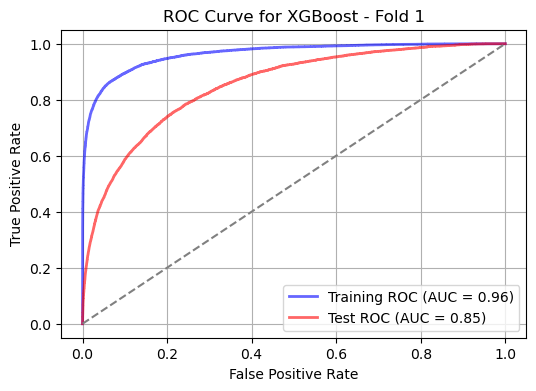

XGBoost Fold 1 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.45, Test F1 Score: 0.16
Training AUC: 0.96, Test AUC: 0.85
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85072
           1       0.84      0.09      0.16      9413

    accuracy                           0.91     94485
   macro avg       0.88      0.54      0.56     94485
weighted avg       0.90      0.91      0.87     94485

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

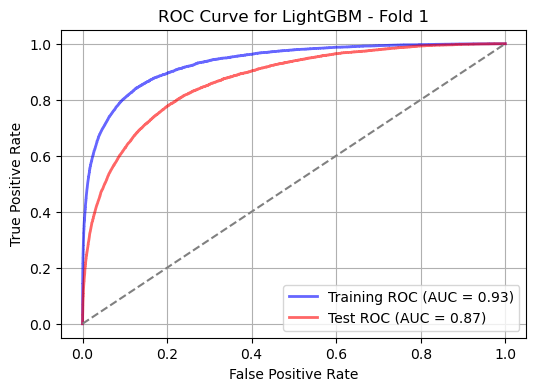

LightGBM Fold 1 Metrics:
Training Accuracy: 0.91, Test Accuracy: 0.91
Training F1 Score: 0.23, Test F1 Score: 0.10
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85072
           1       0.90      0.05      0.10      9413

    accuracy                           0.91     94485
   macro avg       0.90      0.53      0.53     94485
weighted avg       0.90      0.91      0.87     94485



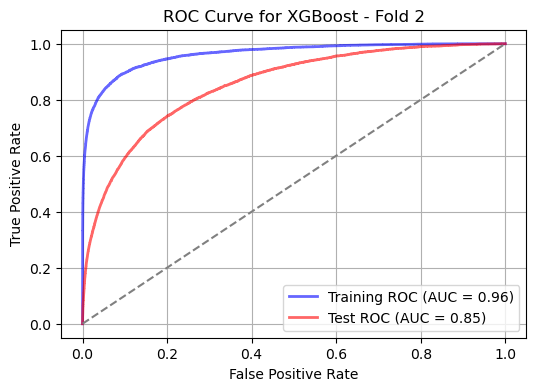

XGBoost Fold 2 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.46, Test F1 Score: 0.16
Training AUC: 0.96, Test AUC: 0.85
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85071
           1       0.83      0.09      0.16      9413

    accuracy                           0.91     94484
   macro avg       0.87      0.54      0.55     94484
weighted avg       0.90      0.91      0.87     94484

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

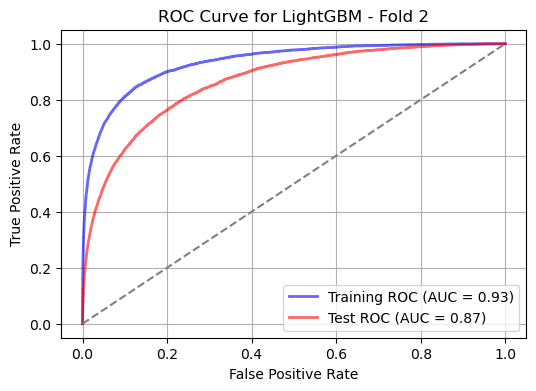

LightGBM Fold 2 Metrics:
Training Accuracy: 0.91, Test Accuracy: 0.91
Training F1 Score: 0.22, Test F1 Score: 0.11
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85071
           1       0.90      0.06      0.11      9413

    accuracy                           0.91     94484
   macro avg       0.90      0.53      0.53     94484
weighted avg       0.91      0.91      0.87     94484



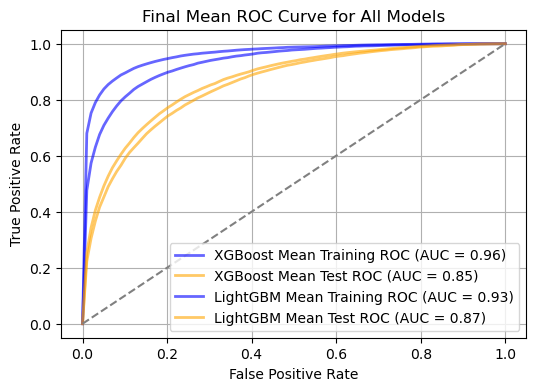


XGBoost Final Cross-Validation Metrics:
Final Accuracy: 0.91
Final F1 Score: 0.16
Final ROC AUC: 0.85

LightGBM Final Cross-Validation Metrics:
Final Accuracy: 0.91
Final F1 Score: 0.10
Final ROC AUC: 0.87


{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 'LightGBM': LGBMClassifier(bagging_fraction=0.85, bagging_freq=1, feature_fraction=1.0,
                learning_rate=0.04, max_bin=1023, min_child_samples=1000,
                n_estimators=200, n_jobs=-1, objective='bin

In [37]:

train_and_evaluate_models_v2(X, y)

## PCA Visualization
This section presents the PCA (Principal Component Analysis) visualization to better understand the data.

In [ ]:
# Apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=0.90):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


In [40]:
def visualize_pca_results(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA to explain 95% of the variance
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

    # 2D visualization of the first two principal components
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled)
    pca_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
    pca_df['target'] = y.values

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['target'], cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA - 2 Component Visualization')
    plt.colorbar(label='Target')
    plt.grid()
    plt.show()

    # Pairplot for the first four components
    pca_4d = PCA(n_components=4)
    X_pca_4d = pca_4d.fit_transform(X_scaled)
    pca_df_4d = pd.DataFrame(X_pca_4d, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    pca_df_4d['target'] = y.values

    sns.pairplot(pca_df_4d, hue='target', diag_kind='kde')
    plt.show()

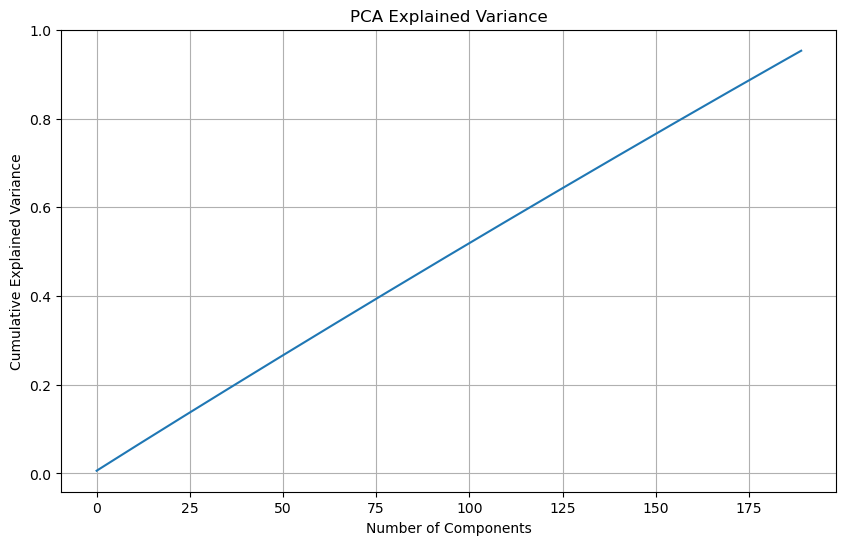

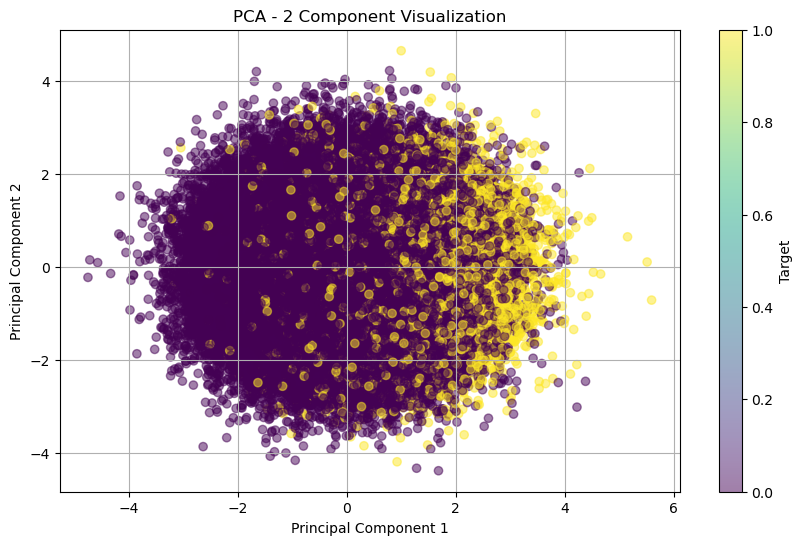

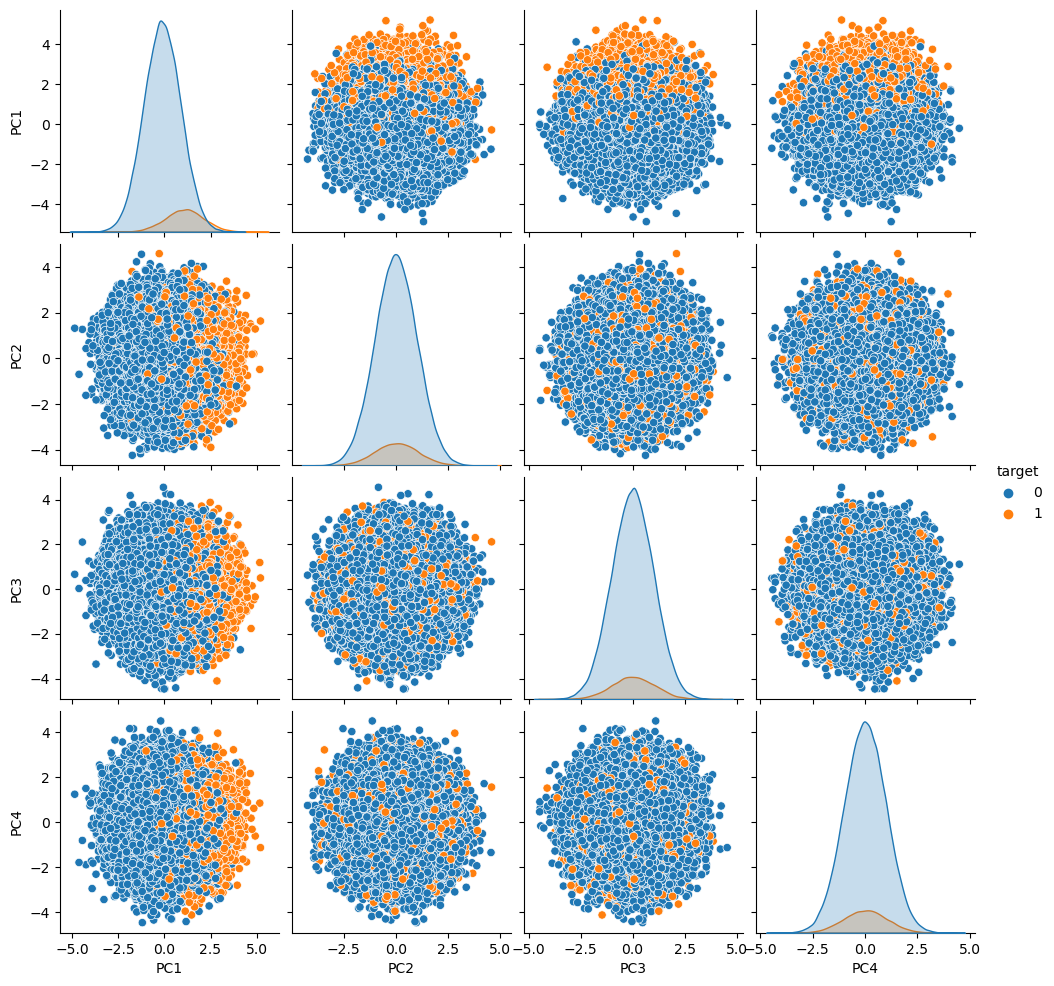

In [41]:
 visualize_pca_results(X, y)

## Version 3: Model with Fake Rows and PCA

This version builds upon the previous one by applying **Principal Component Analysis (PCA)** to the dataset. PCA is used to reduce the dimensionality of the data while retaining most of the variance, which can improve both the model’s training time and its performance by focusing on the most important features.

- **PCA Application:** After adding fake rows, we apply PCA to reduce the feature space while preserving the key variance in the dataset.
- **Model building:** The model is then trained using the transformed dataset (with reduced dimensions) to further improve performance.

In [46]:
# Model training function using StratifiedKFold
def train_and_evaluate_models_with_pca(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=43)
    models = {
        'XGBoost': XGBClassifier(n_estimators=300, learning_rate=0.06, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(learning_rate=0.06, num_leaves=31, max_bin=1023, min_child_samples=1000, reg_alpha=0.1, reg_lambda=0.2, feature_fraction=1.0, bagging_freq=1, bagging_fraction=0.85, objective='binary', n_jobs=-1, n_estimators=300, class_weight='balanced')
    }

    fold_metrics = {name: {'accuracy': [], 'f1_score': [], 'roc_auc': []} for name in models.keys()}
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list_train = {name: [] for name in models.keys()}
    tpr_list_test = {name: [] for name in models.keys()}

    fold_number = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Apply PCA for dimensionality reduction.
        X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled)
        
        for name, model in models.items():
            model.fit(X_train_pca, y_train)
            y_train_pred = model.predict(X_train_pca)
            y_train_pred_prob = model.predict_proba(X_train_pca)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_f1 = f1_score(y_train, y_train_pred)
            train_auc = roc_auc_score(y_train, y_train_pred_prob)
            
            y_test_pred = model.predict(X_test_pca)
            y_test_pred_prob = model.predict_proba(X_test_pca)[:, 1]
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, y_test_pred_prob)

            fold_metrics[name]['accuracy'].append(test_accuracy)
            fold_metrics[name]['f1_score'].append(test_f1)
            fold_metrics[name]['roc_auc'].append(test_auc)

            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
            fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
            tpr_list_train[name].append(np.interp(mean_fpr, fpr_train, tpr_train))
            tpr_list_train[name][-1][0] = 0.0
            tpr_list_test[name].append(np.interp(mean_fpr, fpr_test, tpr_test))
            tpr_list_test[name][-1][0] = 0.0

            plt.figure(figsize=(6, 4))
            plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC (AUC = {train_auc:.2f})', lw=2, alpha=0.6)
            plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {test_auc:.2f})', lw=2, alpha=0.6)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name} - Fold {fold_number}')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()

            print(f"{name} Fold {fold_number} Metrics:")
            print(f"Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
            print(f"Training F1 Score: {train_f1:.2f}, Test F1 Score: {test_f1:.2f}")
            print(f"Training AUC: {train_auc:.2f}, Test AUC: {test_auc:.2f}")
            print(f"Classification Report for Test Set:\n{classification_report(y_test, y_test_pred)}")
            if abs(train_auc - test_auc) > 0.10:
                print("Warning: Possible Overfitting Detected")
        fold_number += 1

    plt.figure(figsize=(6, 4))
    for name in models.keys():
        mean_tpr_train = np.mean(tpr_list_train[name], axis=0)
        mean_tpr_train[-1] = 1.0
        mean_auc_train = auc(mean_fpr, mean_tpr_train)
        plt.plot(mean_fpr, mean_tpr_train, lw=2, linestyle='-', label=f'{name} Mean Training ROC (AUC = {mean_auc_train:.2f})', color='blue', alpha=0.6)

        mean_tpr_test = np.mean(tpr_list_test[name], axis=0)
        mean_tpr_test[-1] = 1.0
        mean_auc_test = auc(mean_fpr, mean_tpr_test)
        plt.plot(mean_fpr, mean_tpr_test, lw=2, linestyle='-', label=f'{name} Mean Test ROC (AUC = {mean_auc_test:.2f})', color='orange', alpha=0.6)

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final Mean ROC Curve for All Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    for name, metrics in fold_metrics.items():
        final_accuracy = np.mean(metrics['accuracy'])
        final_f1 = np.mean(metrics['f1_score'])
        final_roc_auc = np.mean(metrics['roc_auc'])
        print(f"\n{name} Final Cross-Validation Metrics:")
        print(f"Final Accuracy: {final_accuracy:.2f}")
        print(f"Final F1 Score: {final_f1:.2f}")
        print(f"Final ROC AUC: {final_roc_auc:.2f}")

    return models, pca, scaler


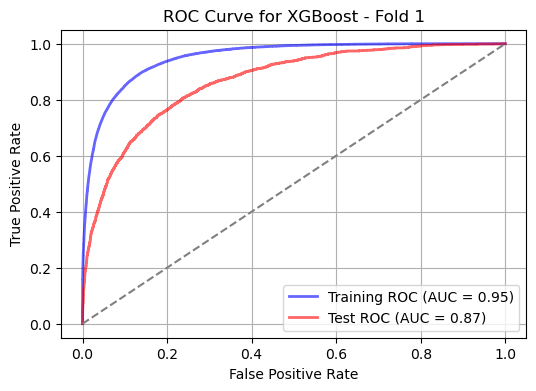

XGBoost Fold 1 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.54, Test F1 Score: 0.38
Training AUC: 0.95, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17015
           1       0.68      0.27      0.38      1882

    accuracy                           0.91     18897
   macro avg       0.80      0.63      0.67     18897
weighted avg       0.90      0.91      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

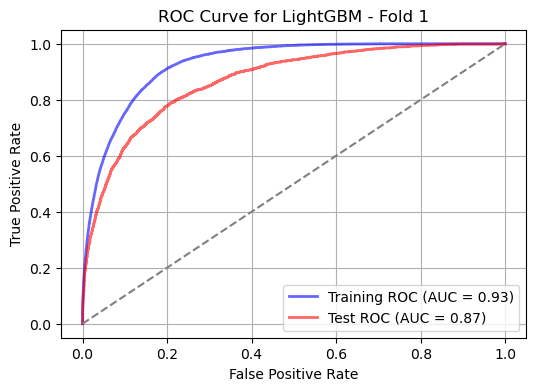

LightGBM Fold 1 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17015
           1       0.32      0.74      0.45      1882

    accuracy                           0.82     18897
   macro avg       0.64      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



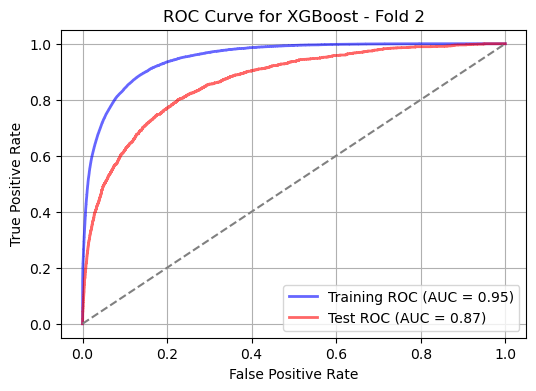

XGBoost Fold 2 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.39
Training AUC: 0.95, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17015
           1       0.70      0.27      0.39      1882

    accuracy                           0.92     18897
   macro avg       0.81      0.63      0.67     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

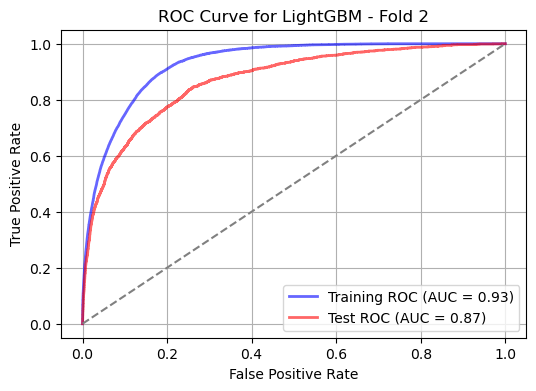

LightGBM Fold 2 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.53, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17015
           1       0.33      0.73      0.45      1882

    accuracy                           0.82     18897
   macro avg       0.65      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



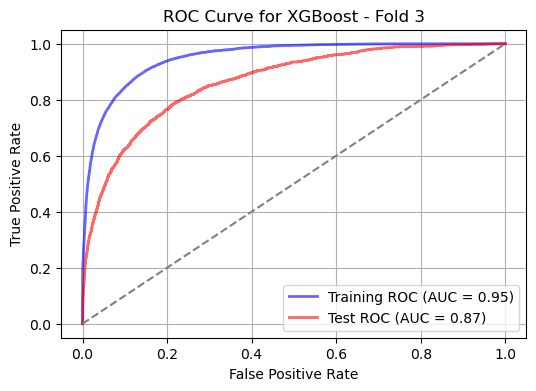

XGBoost Fold 3 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.40
Training AUC: 0.95, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     17015
           1       0.71      0.28      0.40      1882

    accuracy                           0.92     18897
   macro avg       0.82      0.63      0.68     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

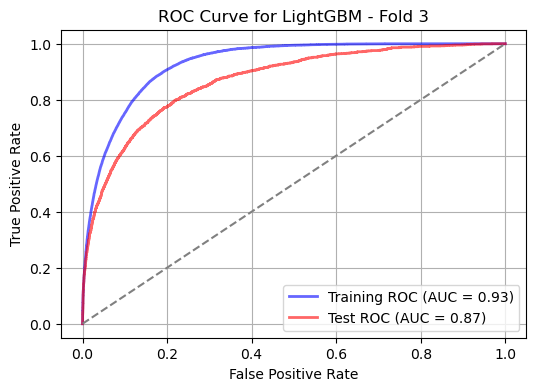

LightGBM Fold 3 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17015
           1       0.33      0.74      0.45      1882

    accuracy                           0.82     18897
   macro avg       0.65      0.79      0.67     18897
weighted avg       0.90      0.82      0.85     18897



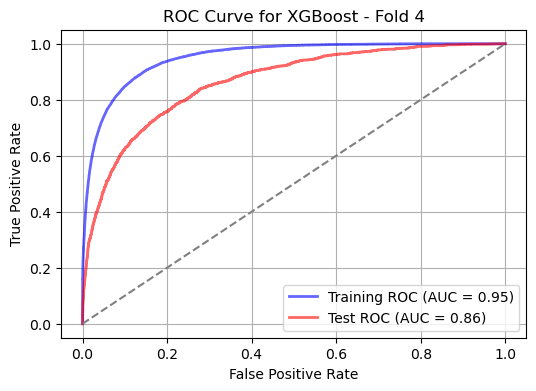

XGBoost Fold 4 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.39
Training AUC: 0.95, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17014
           1       0.70      0.27      0.39      1883

    accuracy                           0.92     18897
   macro avg       0.81      0.63      0.67     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

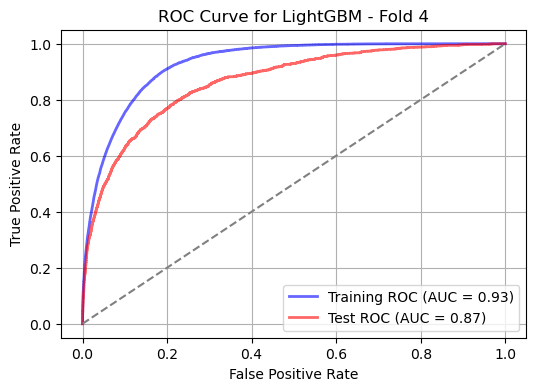

LightGBM Fold 4 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     17014
           1       0.33      0.73      0.45      1883

    accuracy                           0.82     18897
   macro avg       0.65      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



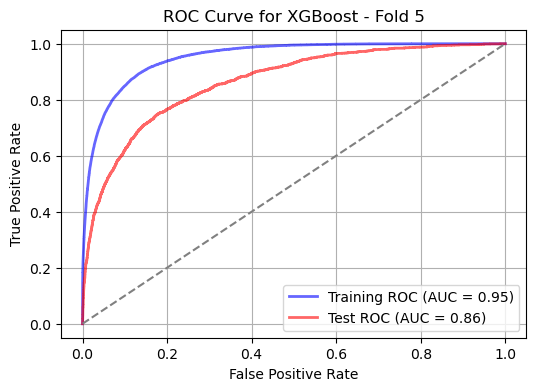

XGBoost Fold 5 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.91
Training F1 Score: 0.54, Test F1 Score: 0.38
Training AUC: 0.95, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17014
           1       0.69      0.26      0.38      1883

    accuracy                           0.91     18897
   macro avg       0.81      0.62      0.67     18897
weighted avg       0.90      0.91      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

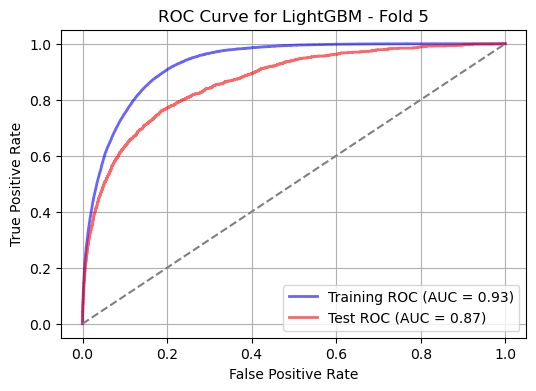

LightGBM Fold 5 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     17014
           1       0.33      0.73      0.45      1883

    accuracy                           0.82     18897
   macro avg       0.65      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



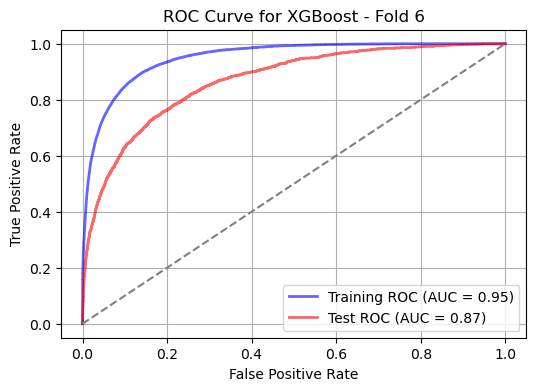

XGBoost Fold 6 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.41
Training AUC: 0.95, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     17014
           1       0.71      0.29      0.41      1883

    accuracy                           0.92     18897
   macro avg       0.82      0.64      0.68     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

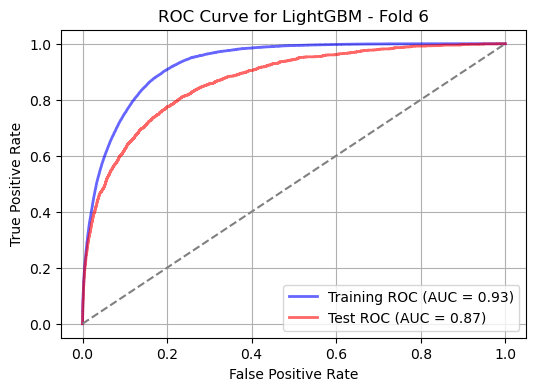

LightGBM Fold 6 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17014
           1       0.33      0.74      0.45      1883

    accuracy                           0.82     18897
   macro avg       0.65      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



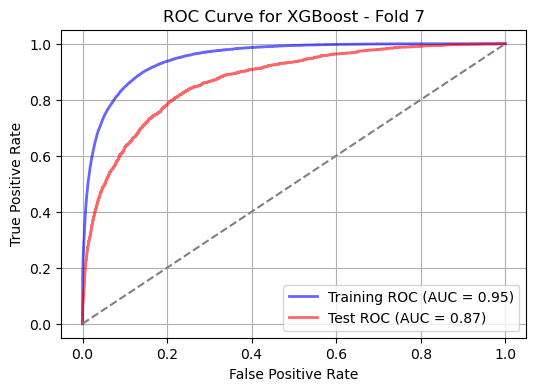

XGBoost Fold 7 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.39
Training AUC: 0.95, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     17014
           1       0.71      0.27      0.39      1883

    accuracy                           0.92     18897
   macro avg       0.82      0.63      0.67     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

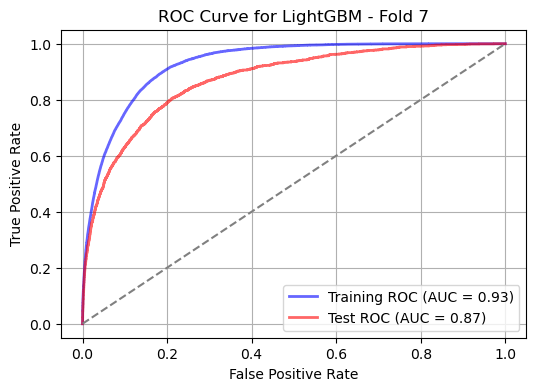

LightGBM Fold 7 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.83
Training F1 Score: 0.52, Test F1 Score: 0.46
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     17014
           1       0.34      0.74      0.46      1883

    accuracy                           0.83     18897
   macro avg       0.65      0.79      0.68     18897
weighted avg       0.90      0.83      0.85     18897



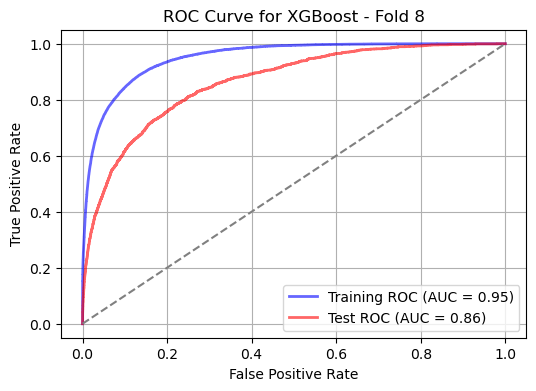

XGBoost Fold 8 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.40
Training AUC: 0.95, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95     17014
           1       0.68      0.28      0.40      1883

    accuracy                           0.92     18897
   macro avg       0.80      0.63      0.68     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

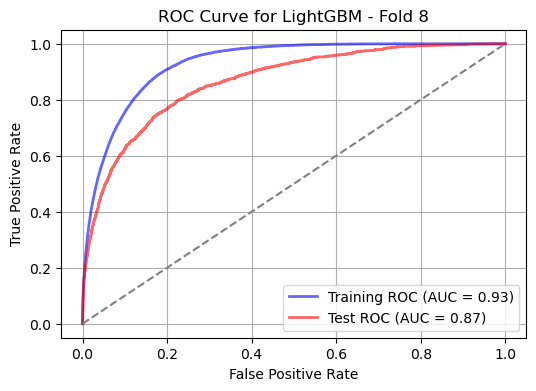

LightGBM Fold 8 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17014
           1       0.33      0.73      0.45      1883

    accuracy                           0.82     18897
   macro avg       0.65      0.78      0.67     18897
weighted avg       0.90      0.82      0.85     18897



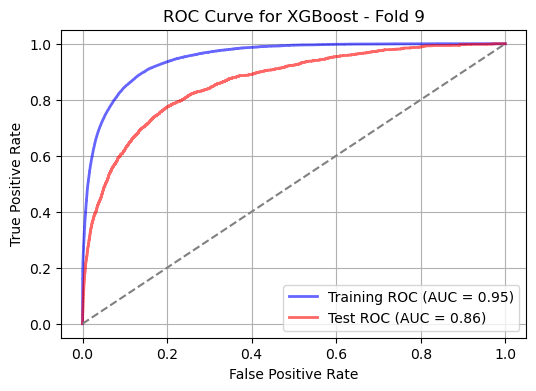

XGBoost Fold 9 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.39
Training AUC: 0.95, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17014
           1       0.70      0.27      0.39      1883

    accuracy                           0.92     18897
   macro avg       0.81      0.63      0.67     18897
weighted avg       0.90      0.92      0.90     18897

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [W

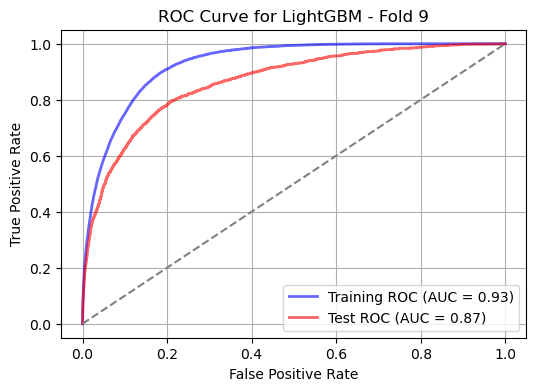

LightGBM Fold 9 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.83
Training F1 Score: 0.52, Test F1 Score: 0.46
Training AUC: 0.93, Test AUC: 0.87
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     17014
           1       0.33      0.74      0.46      1883

    accuracy                           0.83     18897
   macro avg       0.65      0.79      0.68     18897
weighted avg       0.90      0.83      0.85     18897



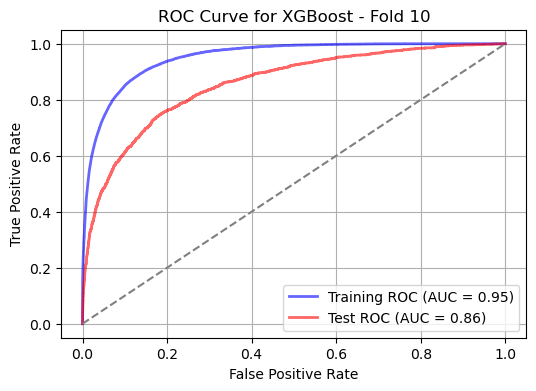

XGBoost Fold 10 Metrics:
Training Accuracy: 0.93, Test Accuracy: 0.92
Training F1 Score: 0.54, Test F1 Score: 0.39
Training AUC: 0.95, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17014
           1       0.70      0.27      0.39      1882

    accuracy                           0.92     18896
   macro avg       0.81      0.63      0.67     18896
weighted avg       0.90      0.92      0.90     18896

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [

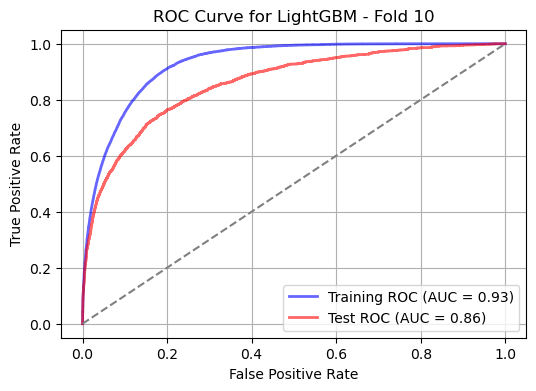

LightGBM Fold 10 Metrics:
Training Accuracy: 0.84, Test Accuracy: 0.82
Training F1 Score: 0.52, Test F1 Score: 0.45
Training AUC: 0.93, Test AUC: 0.86
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     17014
           1       0.33      0.73      0.45      1882

    accuracy                           0.82     18896
   macro avg       0.65      0.78      0.67     18896
weighted avg       0.90      0.82      0.85     18896



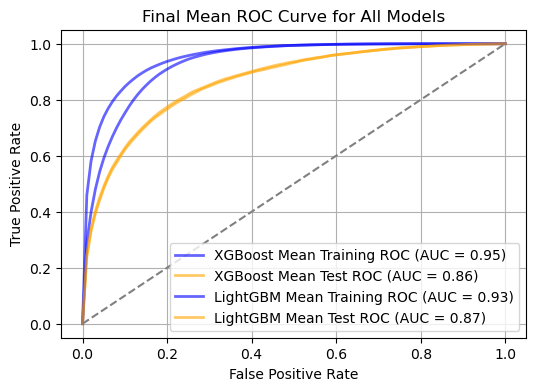


XGBoost Final Cross-Validation Metrics:
Final Accuracy: 0.92
Final F1 Score: 0.39
Final ROC AUC: 0.86

LightGBM Final Cross-Validation Metrics:
Final Accuracy: 0.82
Final F1 Score: 0.45
Final ROC AUC: 0.87


In [47]:
# Train and evaluate models using StratifiedKFold 
models, pca, scaler = train_and_evaluate_models_with_pca(X, y)


## Saving Models and Preprocessing Objects

To use the trained models and preprocessing components later, we save them to disk:

In [ ]:
# Save the models, PCA, and scaler to disk
joblib.dump(models['XGBoost'], r'E:\my_work\dpi\New folder (2)\xgboost_model.pkl')
joblib.dump(models['LightGBM'], r'E:\my_work\dpi\New folder (2)\lightgbm_model.pkl')
joblib.dump(pca, r'E:\my_work\dpi\New folder (2)\pca.pkl')
joblib.dump(scaler, r'E:\my_work\dpi\New folder (2)\scaler.pkl')

## Making Test Predictions and Saving Results

The following code cleans the test data, applies scaling and PCA, makes predictions using the trained models, and saves the results:

<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">
<pre style="color: #2c3e50;">

In [ ]:
# Function to make predictions on the test set and save the output
def make_test_predictions(models, scaler, pca):
    # Clean the test data (note that test data doesn't have 'target' column)
    test_cleaned = test.drop(columns=['ID_code']).copy()

    # Handle any missing values in test data similarly to training data
    test_cleaned.fillna(test_cleaned.mean(), inplace=True)

    # Apply scaling to the test data
    test_scaled = scaler.transform(test_cleaned)

    # Apply PCA to the scaled test data
    test_pca = pca.transform(test_scaled)

    # Predict probabilities using trained models and save results
    id_codes = test['ID_code']
    results_df = pd.DataFrame({'ID_code': id_codes})

    # Assuming you want to make predictions using all models
    for name, model in models.items():
        predictions = model.predict_proba(test_pca)[:, 1]
        results_df[f'{name}_predicted_probabilities'] = predictions

    # Save the results to a CSV file
    results_df.to_csv(r'E:\my_work\dpi\predictions_with_id.csv', index=False)

    # Display the first few rows of the results for verification
    print(results_df.head())

In [ ]:
make_test_predictions(models, scaler, pca)
